This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
from PIL import Image
import time
import shutil

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import *


# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [2]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)
categories_df = pd.read_csv('categories_name_to_id.csv')

c:\users\yang\anaconda3\envs\cdiscount\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
idx2l1 = list(categories_df['category_level1'])
idx2l2 = list(categories_df['category_level2'])

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [4]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset
import torch.nn.functional as F

In [5]:
class BSONIterator(Dataset):
    def __init__(self, bson_file, images_df, offsets_df, transform, lock, mode):
        super(BSONIterator, self).__init__()
        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.transform = transform
        self.lock = lock
        self.mode = mode

    def __getitem__(self, idx):
        # Protect file and dataframe access with a lock.
        with self.lock:
            image_row = self.images_df.iloc[idx]
            product_id = image_row["product_id"]
            offset_row = self.offsets_df.loc[product_id]
            # Random access this product's data from the BSON file.
            self.file.seek(offset_row["offset"])
            item_data = self.file.read(offset_row["length"])
        # Grab the image from the product.
        item = bson.BSON.decode(item_data)
        img_idx = image_row["img_idx"]
        bson_img = item["imgs"][img_idx]["picture"]

        # Load the image.
        image = io.BytesIO(bson_img)
        img = Image.open(image)
        x = self.transform(img)
        if self.mode == 'train':
            idx = int(image_row["category_idx"])
            level1 = int(idx2l1[idx])
            level2 = int(idx2l2[idx])
            
            target1 = torch.LongTensor([level1])
            target2 = torch.LongTensor([level2])
            target3 = torch.LongTensor([idx])
            return x, target1, target2, target3 #for the sake of pin_memory and async
        if self.mode == 'valid':
            y = image_row["category_idx"]
            return x, y
        else:
            return x
    
    def __len__(self):
        return len(self.images_df)

In [6]:
data_dir = "./input/"
file_dir = r'C:\Users\YANG\Downloads\cdiscount'
train_bson_path = os.path.join(file_dir, "train.bson")
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [7]:
import threading
lock = threading.Lock()

In [8]:
# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# transform_train = T.Compose([T.CenterCrop(size=160), T.RandomHorizontalFlip(), T.ToTensor(),
#                              T.Normalize(mean=mean, std=std)])
# transform_val = T.Compose([T.CenterCrop(size=160), T.ToTensor(),T.Normalize(mean=mean, std=std)])

In [9]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_train = T.Compose([T.RandomHorizontalFlip(), 
                             T.ToTensor(),T.Normalize(mean=mean, std=std)])
transform_val = T.Compose([T.ToTensor(),T.Normalize(mean=mean, std=std)])

Create a generator for training and a generator for validation.

In [10]:
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, transform_train, lock, mode = 'train')
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df, transform_val, lock, mode = 'valid')

In [11]:
print(len(train_gen), len(val_gen))

989828 241932


In [12]:
batch_size = 256
loader_train = DataLoader(train_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(train_gen), num_workers=0, pin_memory = True)
loader_val = DataLoader(val_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(val_gen), num_workers=0, pin_memory = True)

# Part 3: Training

Create a very Resnet18 model and train it, to test that the generators work.

**SEResNet18**

In [13]:
model = torchvision.models.resnet18(pretrained=True)
model.avgpool = nn.AvgPool2d(kernel_size = 6)
model.fc = nn.Linear(in_features=512, out_features= 49 + 483 + 5270) #or 49 + 483 + 5270
for layer in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2]:
    for param in layer.parameters():
        param.requires_grad = False

**ResNet50**

In [14]:
# model = torchvision.models.resnet50(pretrained=True)
# model.avgpool = nn.AvgPool2d(kernel_size = 5)
# model.fc = nn.Linear(in_features=2048, out_features=5270) #or 49 + 483 + 5270

In [15]:
init.kaiming_normal(model.fc.weight.data)
model.fc.bias.data.zero_()
model.cuda()


ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [16]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch, denominator = 2):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // denominator))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.max(dim=1)
    correct = pred.eq(target)
    res = []
    for k in topk:
        correct_k = correct.float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# def accuracy(output, target, topk=(1,)):
#     """Computes the precision@k for the specified values of k"""
#     maxk = max(topk)
#     batch_size = target.size(0)

#     _, pred = output.topk(maxk, 1, True, True)
#     pred = pred.t()
#     correct = pred.eq(target.view(1, -1).expand_as(pred))

#     res = []
#     for k in topk:
#         correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#         res.append(correct_k.mul_(100.0 / batch_size))
#     return res

In [17]:
def train(train_loader, model, criterion, optimizer, weights, epoch, print_freq = 50):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    loss_log = []
    acc_log = []
#     top5 = AverageMeter() #only need top1

    # switch to train mode
    model.train()

    end = time.time()
    for i, (img, target1, target2, target3) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        img = img.cuda(async=True)
        img_var = Variable(img)
        
        target1 = target1.view(-1).cuda(async=True)
        target1_var = Variable(target1)
        target2 = target2.view(-1).cuda(async=True)
        target2_var = Variable(target2)
        target3 = target3.view(-1).cuda(async=True)
        target3_var = Variable(target3)

        # compute output
        output = model(img_var)
        loss1 = criterion(output[:, :49], target1_var)
        loss2=  criterion(output[:, 49:532], target2_var)
        loss3=  criterion(output[:, 532:], target3_var)
        loss = loss1*weights[0] + loss2*weights[1] + loss3*weights[2]
        # measure accuracy and record loss
        prec1 = accuracy(output[:, 532:].data, target3, topk=(1, ))[0]#only need top1
        losses.update(loss.data[0], img.size(0)) #[0] to take out the float inside torch.Tensor
        top1.update(prec1[0], img.size(0))
        loss_log.append(losses.val)
        acc_log.append(top1.val)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))
    return loss_log, acc_log

In [18]:
def validate(val_loader, model, print_freq=50):
    batch_time = AverageMeter()
#     losses = AverageMeter()
    top1 = AverageMeter()
#     top5 = AverageMeter() #only need top1

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (img, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img, volatile=True)
        target_var = Variable(target, volatile=True)

        # compute output
        output = model(img_var)[:, 532:]
#         loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]#only need top1
#         losses.update(loss.data[0], img.size(0))
        top1.update(prec1[0], img.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [19]:
def main():
    best_prec1 = 52
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-2, momentum=0.9, 
                          weight_decay=0)
    weights = [1, 1, 1]
    resume = None
    start_epoch = 0
    epochs = 3
    arch = 'resnet18'

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    for epoch in range(start_epoch, epochs):
    #     if args.distributed:
    #         train_sampler.set_epoch(epoch)
        adjust_learning_rate(lr=1e-2, optimizer=optimizer, epoch=epoch, denominator=2)

        # train for one epoch
        for weights in [[1, 0, 0], [0, 0, 1]]:
            loss_log, acc_log = train(train_loader=loader_train, model=model, criterion=criterion,
                                      weights = weights, optimizer=optimizer, epoch=epoch)

        # evaluate on validation set
            prec1 = validate(val_loader=loader_val, model=model)
            
            #plot loss and acc
            fig = plt.figure(figsize = (6,3), dpi = 1200)
            loss_log = np.array(list(map(lambda x: x.data[0], loss_log)))
            ax1 = plt.subplot(121)
            ax1.plot(loss_log)
            ax1.set_ylabel('Loss', weight = 'bold')
            acc_log = np.array(acc_log)
            ax2 = plt.subplot(122)
            ax2.plot(acc_log)
            ax2.set_ylabel('Train_accuracy', weight = 'bold')
            np.savetxt(X=np.vstack((loss_log, acc_log)), fname='loss_acc_log.txt', fmt='%.3f')

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)


Epoch: [0][0/3867]	Time 1.578 (1.578)	Data 0.812 (0.812)	Loss 5.6351 (5.6351)	Prec@1 0.000 (0.000)
Epoch: [0][50/3867]	Time 0.456 (0.443)	Data 0.331 (0.308)	Loss 2.0099 (2.6146)	Prec@1 0.000 (0.000)
Epoch: [0][100/3867]	Time 0.460 (0.434)	Data 0.332 (0.306)	Loss 1.6980 (2.2399)	Prec@1 0.000 (0.000)
Epoch: [0][150/3867]	Time 0.442 (0.440)	Data 0.314 (0.314)	Loss 1.4350 (2.0724)	Prec@1 0.000 (0.003)
Epoch: [0][200/3867]	Time 0.477 (0.442)	Data 0.362 (0.317)	Loss 1.6650 (1.9653)	Prec@1 0.000 (0.006)
Epoch: [0][250/3867]	Time 0.456 (0.445)	Data 0.341 (0.320)	Loss 1.5505 (1.8939)	Prec@1 0.000 (0.006)
Epoch: [0][300/3867]	Time 0.479 (0.447)	Data 0.361 (0.323)	Loss 1.4190 (1.8333)	Prec@1 0.000 (0.008)
Epoch: [0][350/3867]	Time 0.453 (0.450)	Data 0.328 (0.325)	Loss 1.4835 (1.7859)	Prec@1 0.000 (0.007)
Epoch: [0][400/3867]	Time 0.459 (0.451)	Data 0.345 (0.327)	Loss 1.5171 (1.7492)	Prec@1 0.000 (0.006)
Epoch: [0][450/3867]	Time 0.462 (0.452)	Data 0.339 (0.328)	Loss 1.5632 (1.7171)	Prec@1 0.000 (

Epoch: [0][3500/3867]	Time 0.444 (0.434)	Data 0.319 (0.311)	Loss 3.2573 (3.6639)	Prec@1 47.266 (40.810)
Epoch: [0][3550/3867]	Time 0.444 (0.434)	Data 0.318 (0.311)	Loss 2.8816 (3.6557)	Prec@1 50.000 (40.887)
Epoch: [0][3600/3867]	Time 0.445 (0.434)	Data 0.318 (0.311)	Loss 2.9617 (3.6474)	Prec@1 48.047 (40.971)
Epoch: [0][3650/3867]	Time 0.446 (0.435)	Data 0.320 (0.311)	Loss 2.8761 (3.6393)	Prec@1 48.828 (41.048)
Epoch: [0][3700/3867]	Time 0.442 (0.435)	Data 0.316 (0.311)	Loss 2.9515 (3.6329)	Prec@1 45.312 (41.105)
Epoch: [0][3750/3867]	Time 0.448 (0.435)	Data 0.322 (0.311)	Loss 2.9872 (3.6262)	Prec@1 48.047 (41.167)
Epoch: [0][3800/3867]	Time 0.441 (0.435)	Data 0.321 (0.311)	Loss 2.8587 (3.6181)	Prec@1 52.734 (41.247)
Epoch: [0][3850/3867]	Time 0.445 (0.435)	Data 0.320 (0.311)	Loss 3.1680 (3.6105)	Prec@1 45.312 (41.324)
Test: [0/946]	Time 0.411 (0.411)	Prec@1 41.406 (41.406)
Test: [50/946]	Time 0.407 (0.412)	Prec@1 45.312 (46.247)
Test: [100/946]	Time 0.414 (0.413)	Prec@1 47.656 (46.25

Epoch: [1][2500/3867]	Time 0.441 (0.436)	Data 0.316 (0.312)	Loss 2.8064 (2.8122)	Prec@1 47.266 (49.048)
Epoch: [1][2550/3867]	Time 0.442 (0.436)	Data 0.316 (0.313)	Loss 2.5941 (2.8094)	Prec@1 52.344 (49.087)
Epoch: [1][2600/3867]	Time 0.443 (0.436)	Data 0.318 (0.313)	Loss 2.7049 (2.8079)	Prec@1 49.219 (49.104)
Epoch: [1][2650/3867]	Time 0.432 (0.436)	Data 0.318 (0.313)	Loss 2.6742 (2.8056)	Prec@1 48.828 (49.129)
Epoch: [1][2700/3867]	Time 0.439 (0.436)	Data 0.316 (0.313)	Loss 2.5050 (2.8040)	Prec@1 54.688 (49.142)
Epoch: [1][2750/3867]	Time 0.445 (0.436)	Data 0.319 (0.313)	Loss 2.4586 (2.8031)	Prec@1 52.344 (49.156)
Epoch: [1][2800/3867]	Time 0.443 (0.436)	Data 0.317 (0.313)	Loss 2.6635 (2.8009)	Prec@1 52.734 (49.187)
Epoch: [1][2850/3867]	Time 0.444 (0.436)	Data 0.318 (0.313)	Loss 2.6394 (2.7984)	Prec@1 48.828 (49.217)
Epoch: [1][2900/3867]	Time 0.444 (0.436)	Data 0.318 (0.313)	Loss 3.0347 (2.7974)	Prec@1 49.219 (49.226)
Epoch: [1][2950/3867]	Time 0.442 (0.436)	Data 0.316 (0.313)	Loss

Epoch: [2][1500/3867]	Time 0.414 (0.419)	Data 0.296 (0.296)	Loss 2.3368 (2.3203)	Prec@1 55.078 (55.982)
Epoch: [2][1550/3867]	Time 0.407 (0.419)	Data 0.292 (0.296)	Loss 2.4793 (2.3199)	Prec@1 55.859 (55.984)
Epoch: [2][1600/3867]	Time 0.417 (0.419)	Data 0.292 (0.296)	Loss 2.3281 (2.3190)	Prec@1 58.203 (55.994)
Epoch: [2][1650/3867]	Time 0.434 (0.419)	Data 0.309 (0.296)	Loss 2.2758 (2.3167)	Prec@1 55.859 (56.028)
Epoch: [2][1700/3867]	Time 0.415 (0.419)	Data 0.290 (0.296)	Loss 2.2231 (2.3157)	Prec@1 60.938 (56.042)
Epoch: [2][1750/3867]	Time 0.427 (0.419)	Data 0.305 (0.296)	Loss 2.2190 (2.3144)	Prec@1 58.594 (56.046)
Epoch: [2][1800/3867]	Time 0.422 (0.419)	Data 0.297 (0.296)	Loss 2.2790 (2.3135)	Prec@1 61.719 (56.063)
Epoch: [2][1850/3867]	Time 0.417 (0.419)	Data 0.291 (0.296)	Loss 2.0762 (2.3133)	Prec@1 58.594 (56.058)
Epoch: [2][1900/3867]	Time 0.417 (0.419)	Data 0.292 (0.296)	Loss 2.3594 (2.3121)	Prec@1 51.172 (56.081)
Epoch: [2][1950/3867]	Time 0.426 (0.419)	Data 0.309 (0.296)	Loss

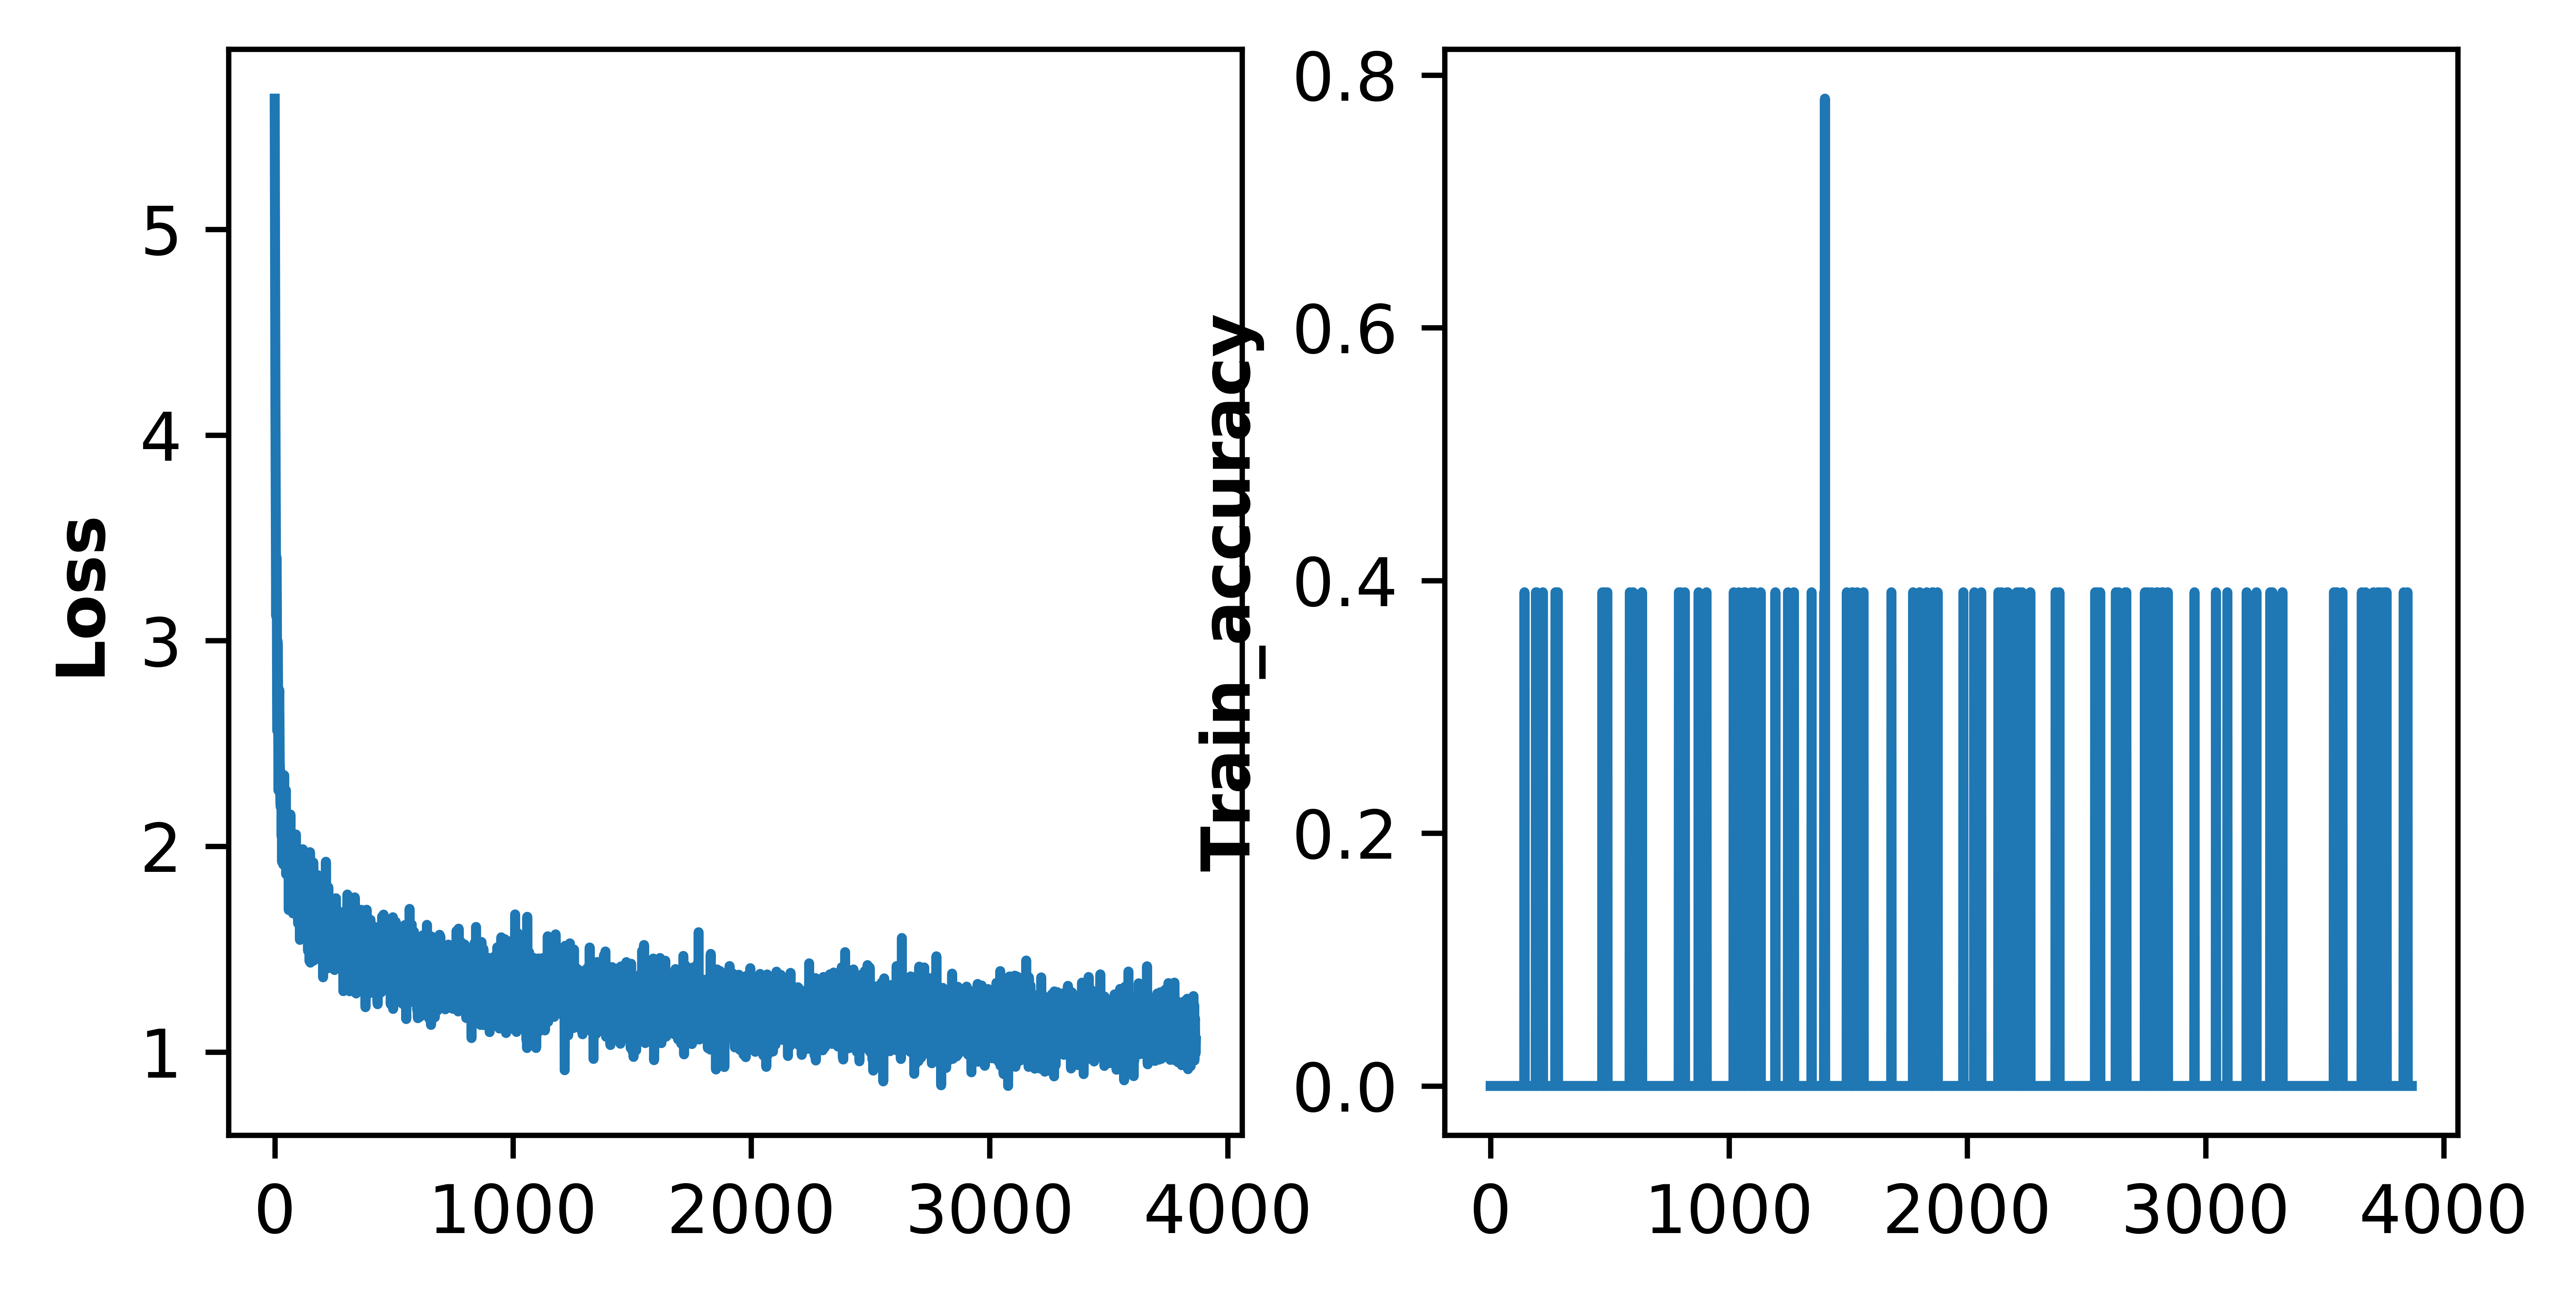

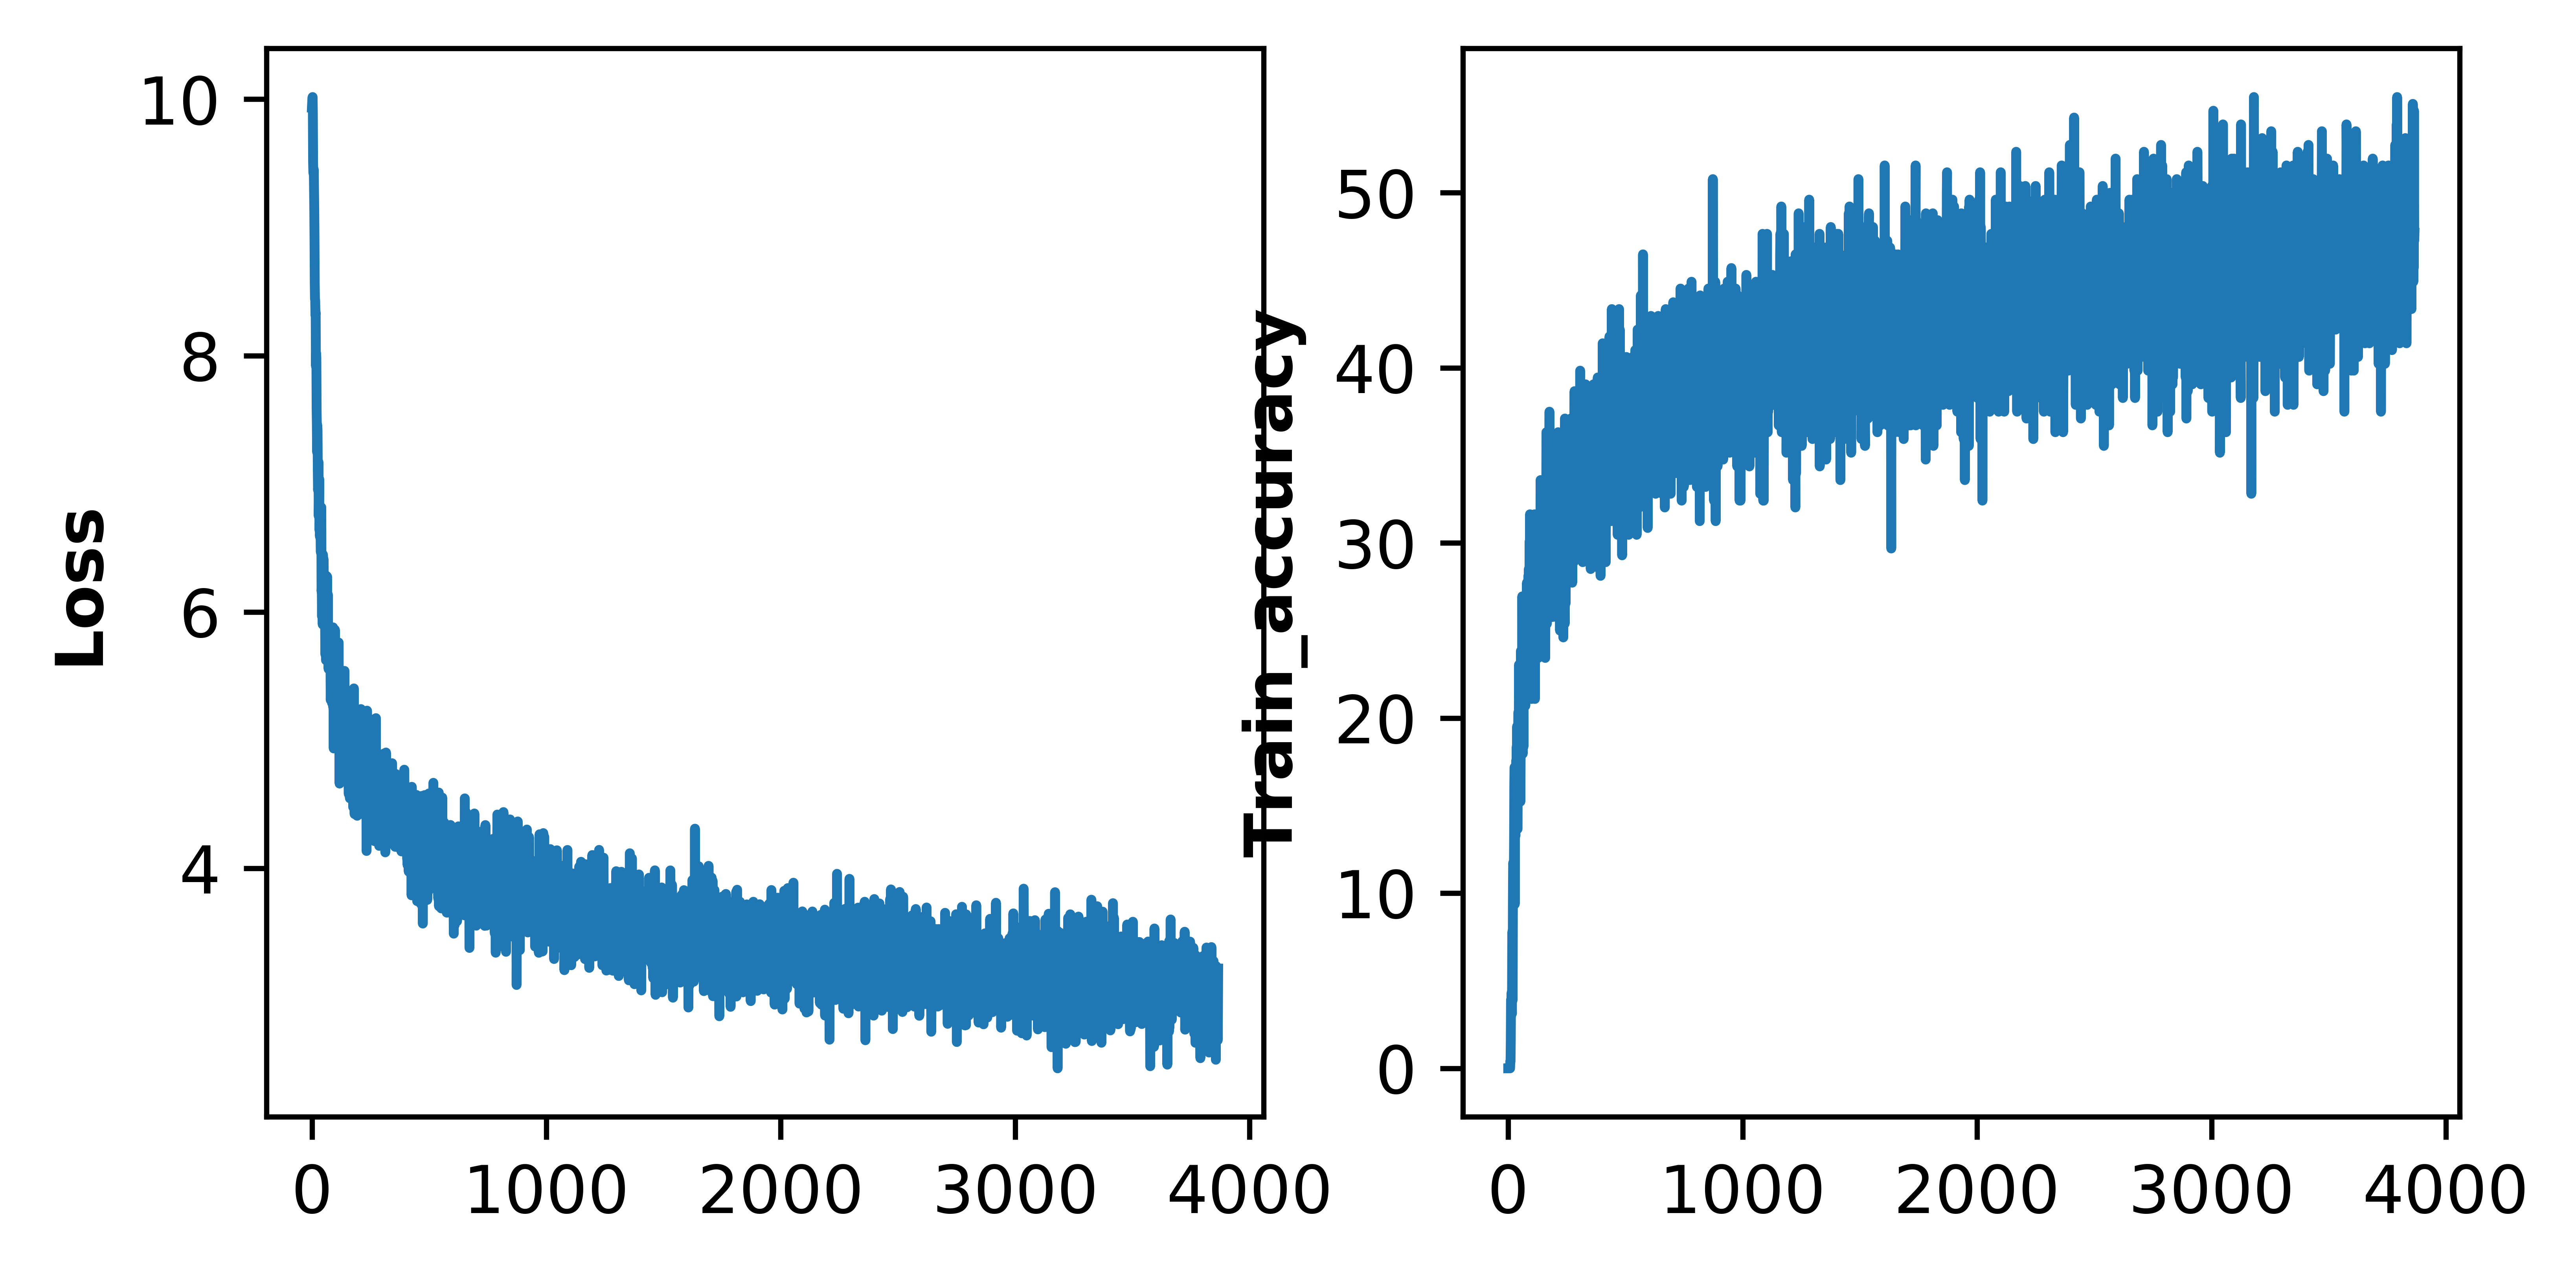

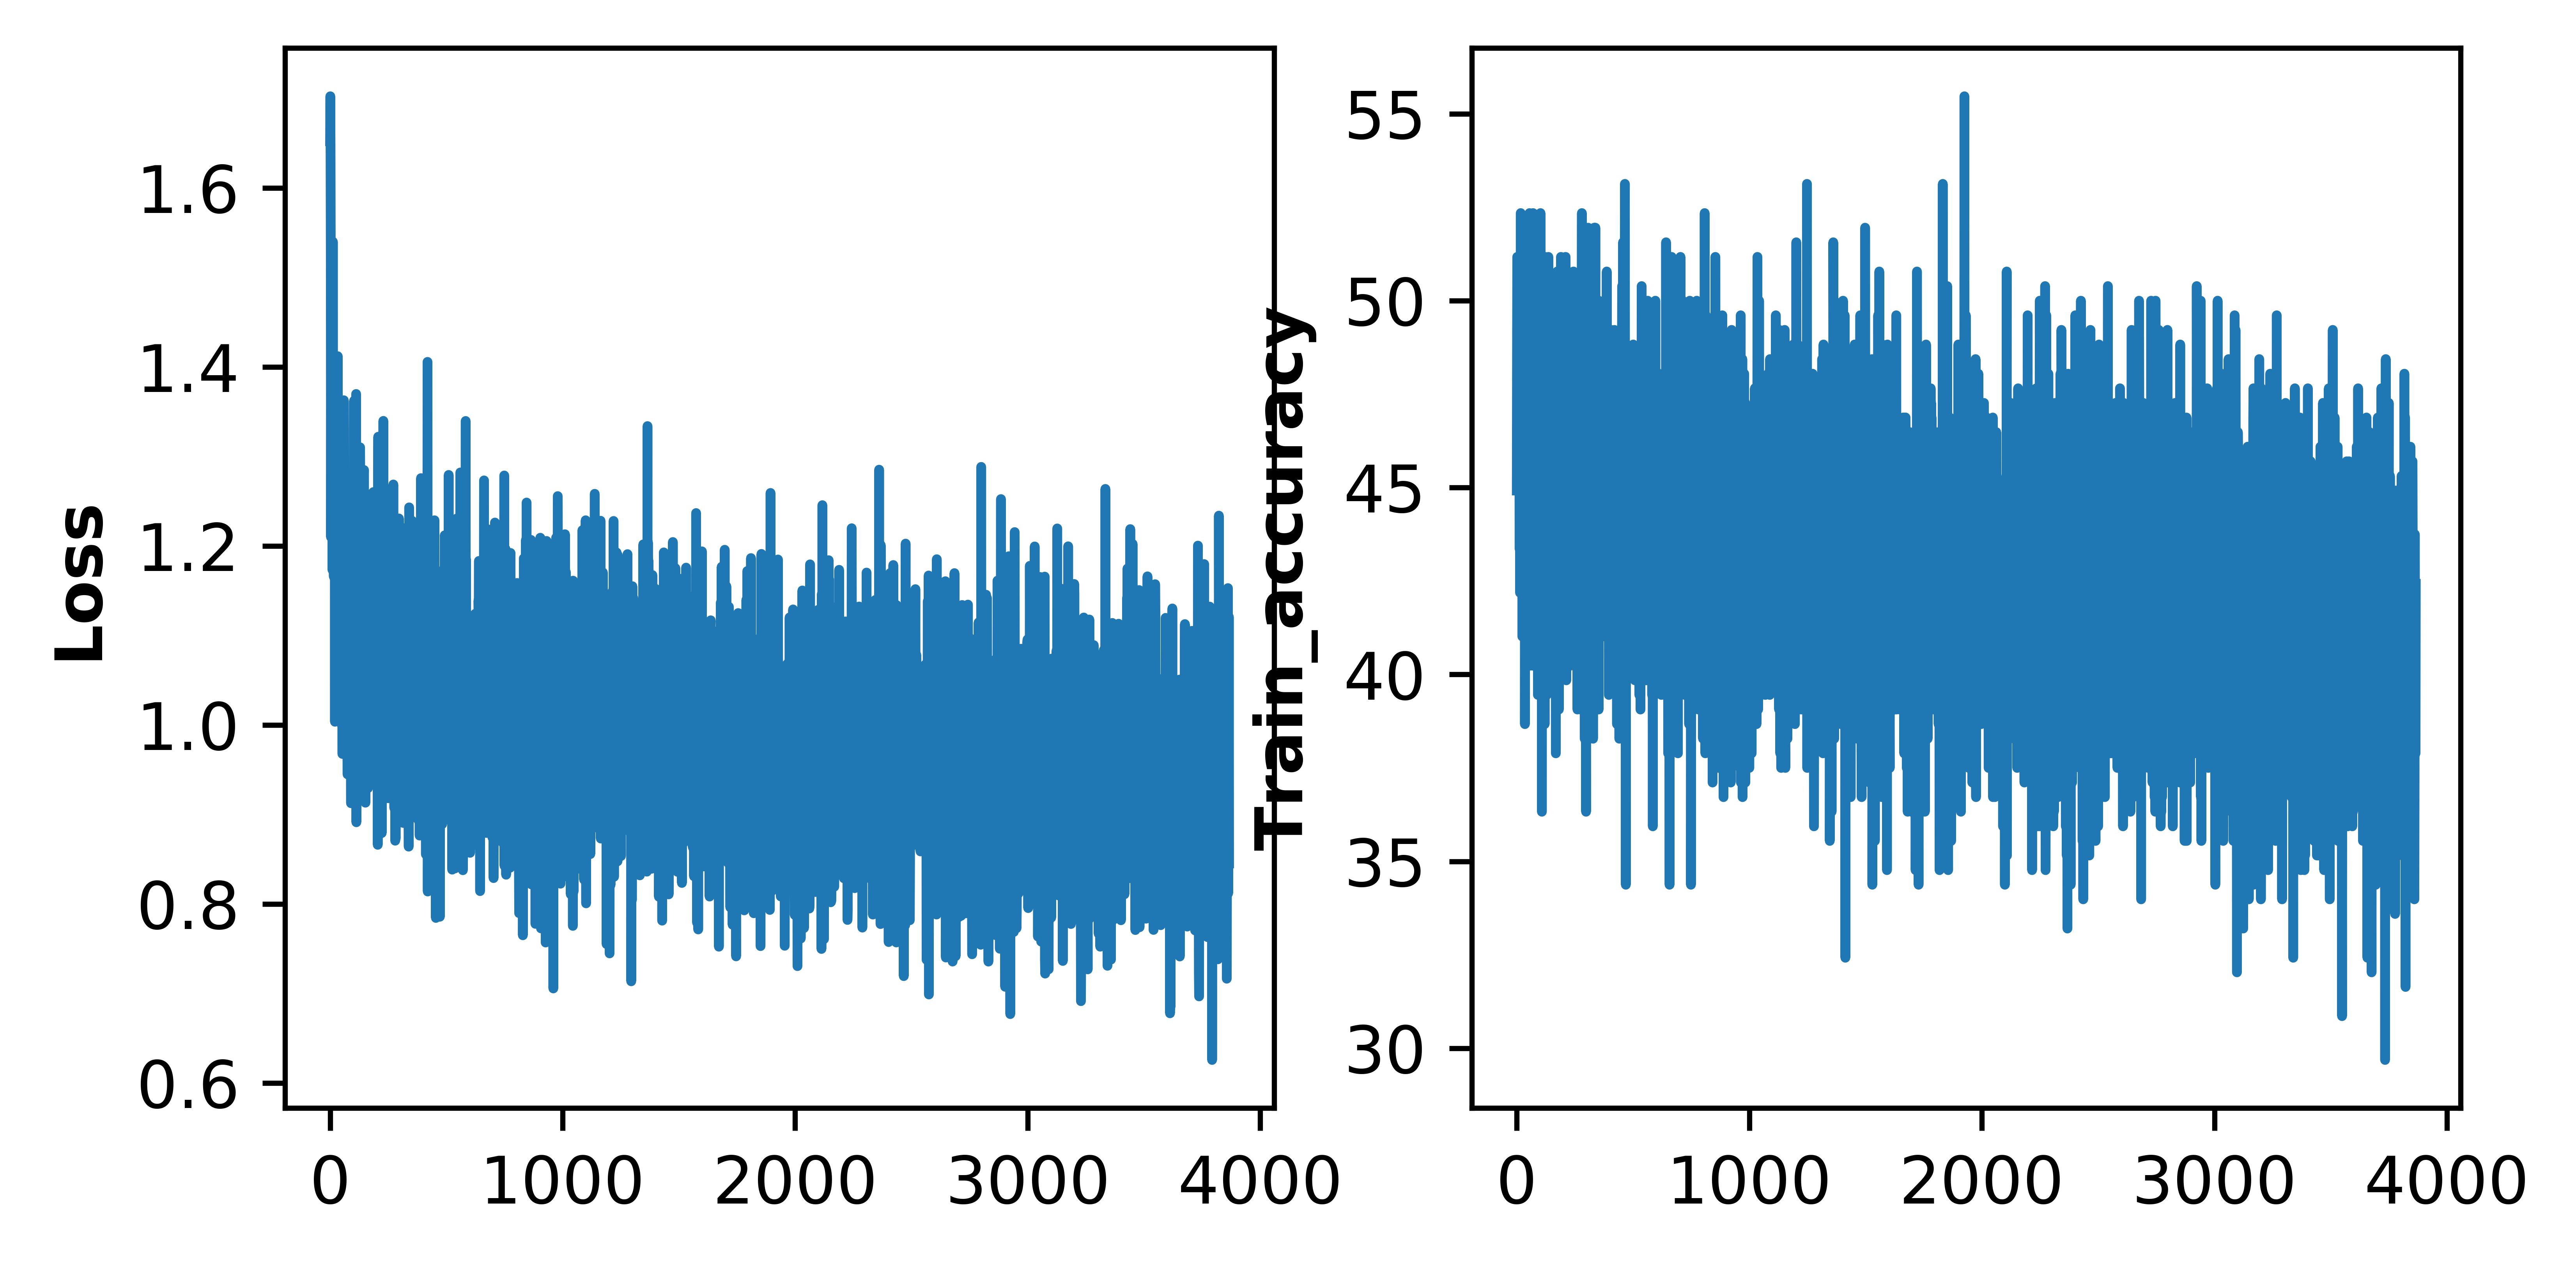

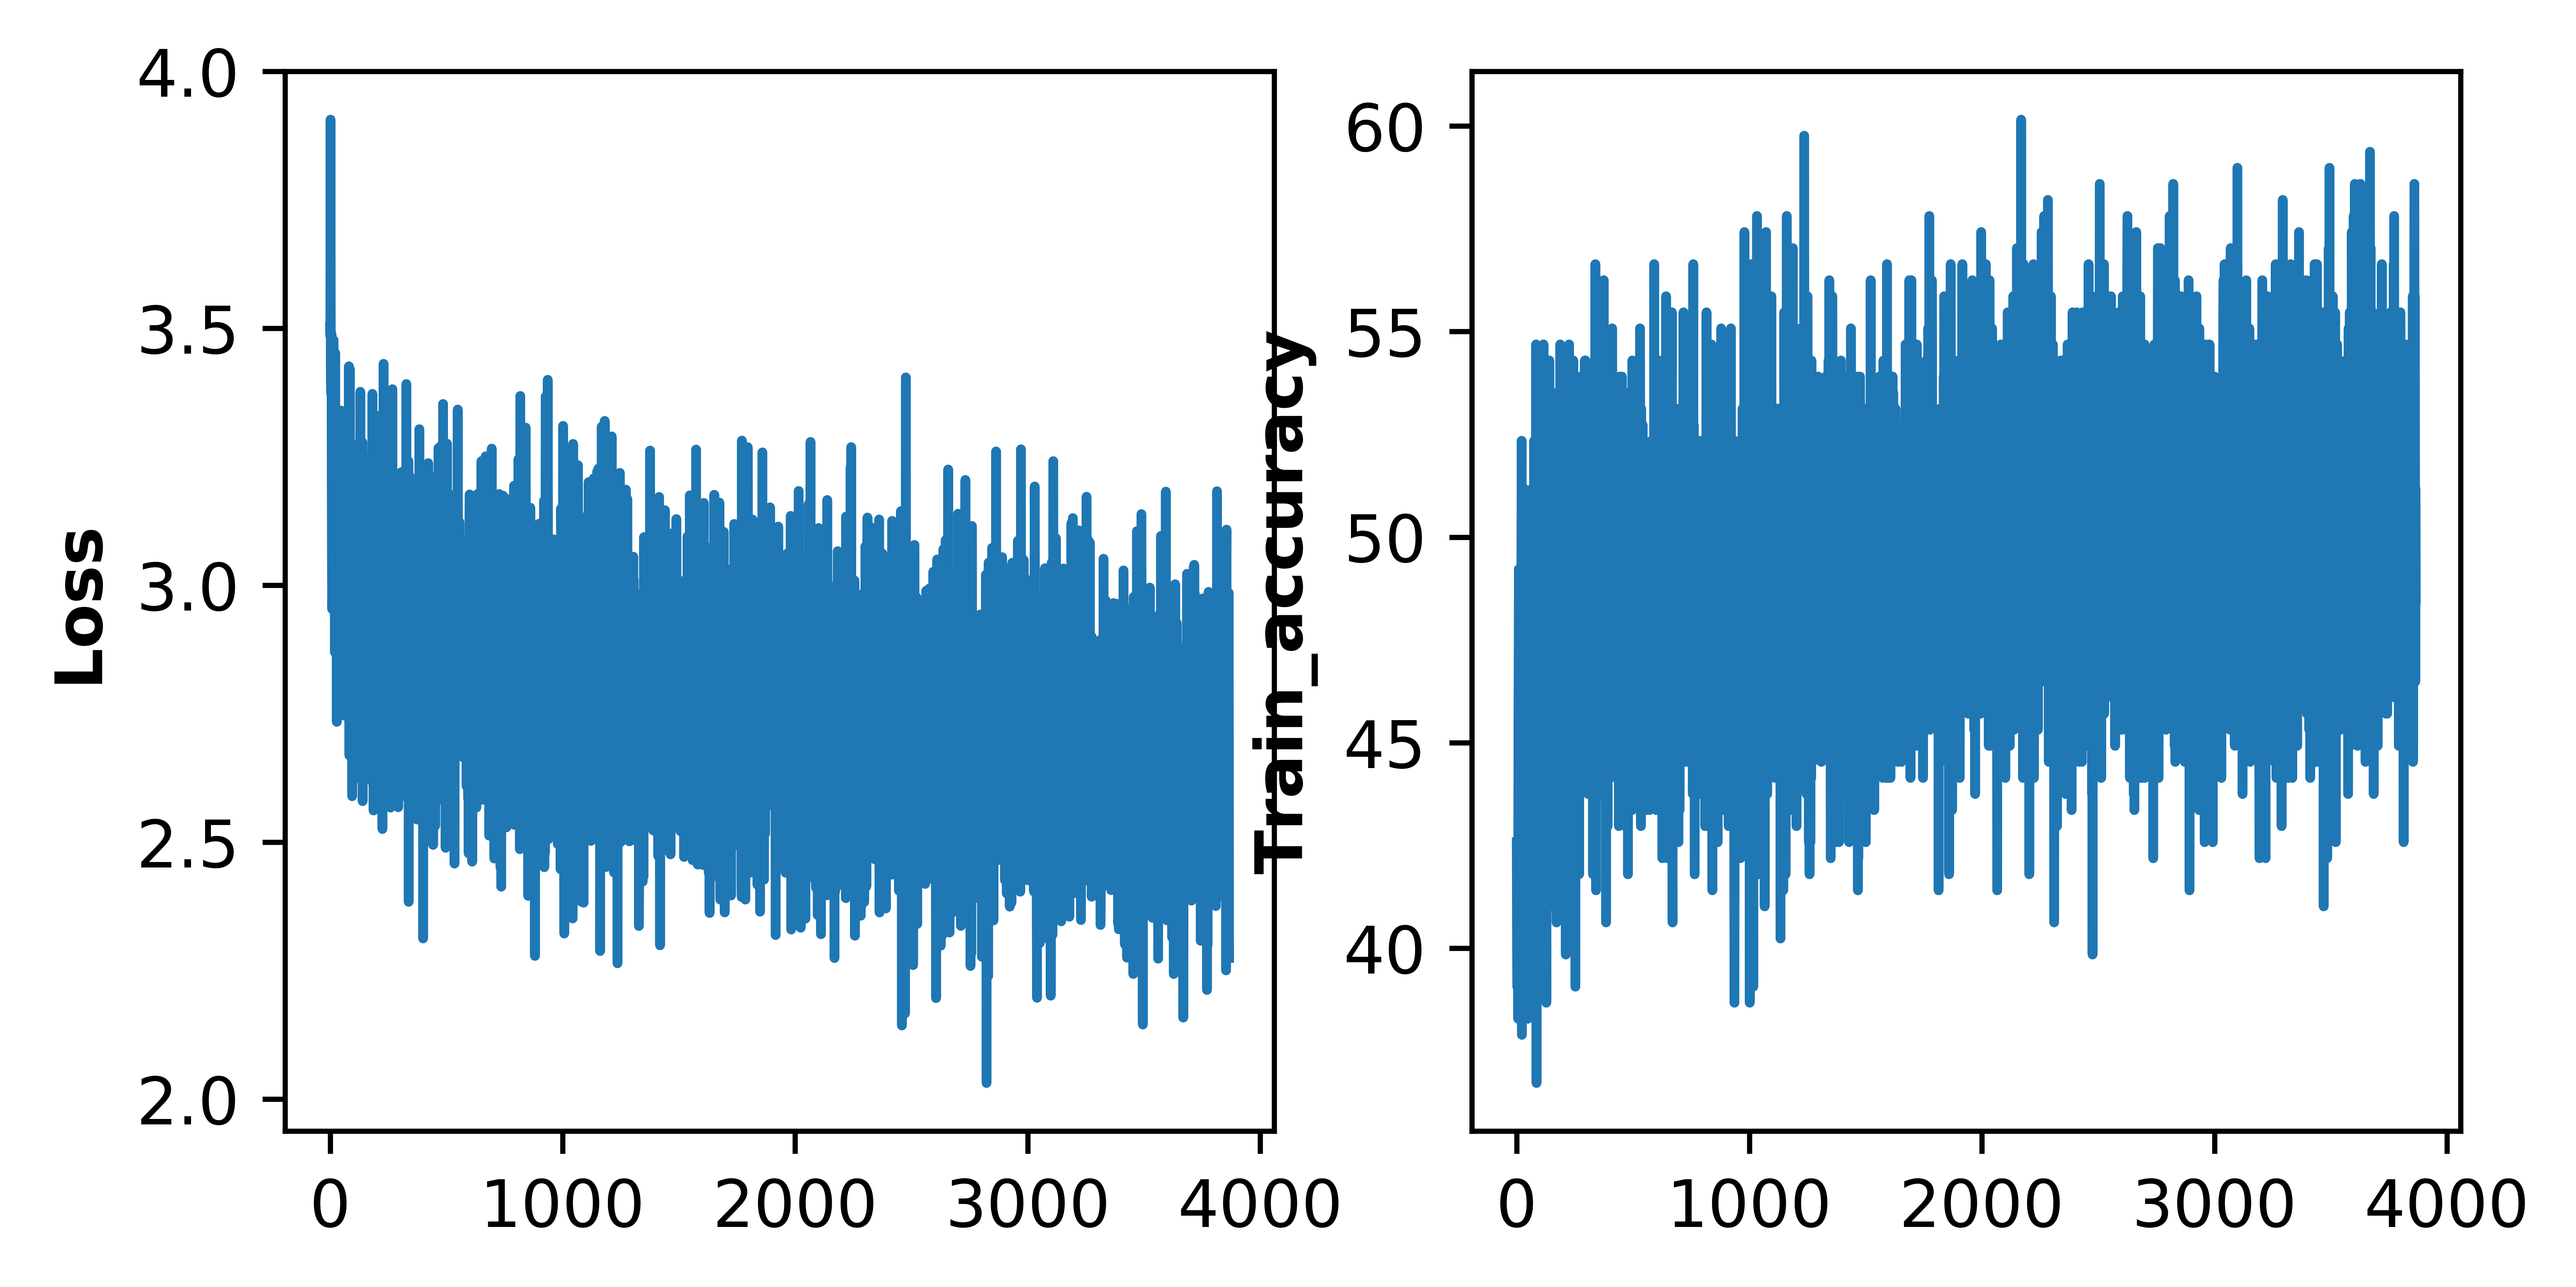

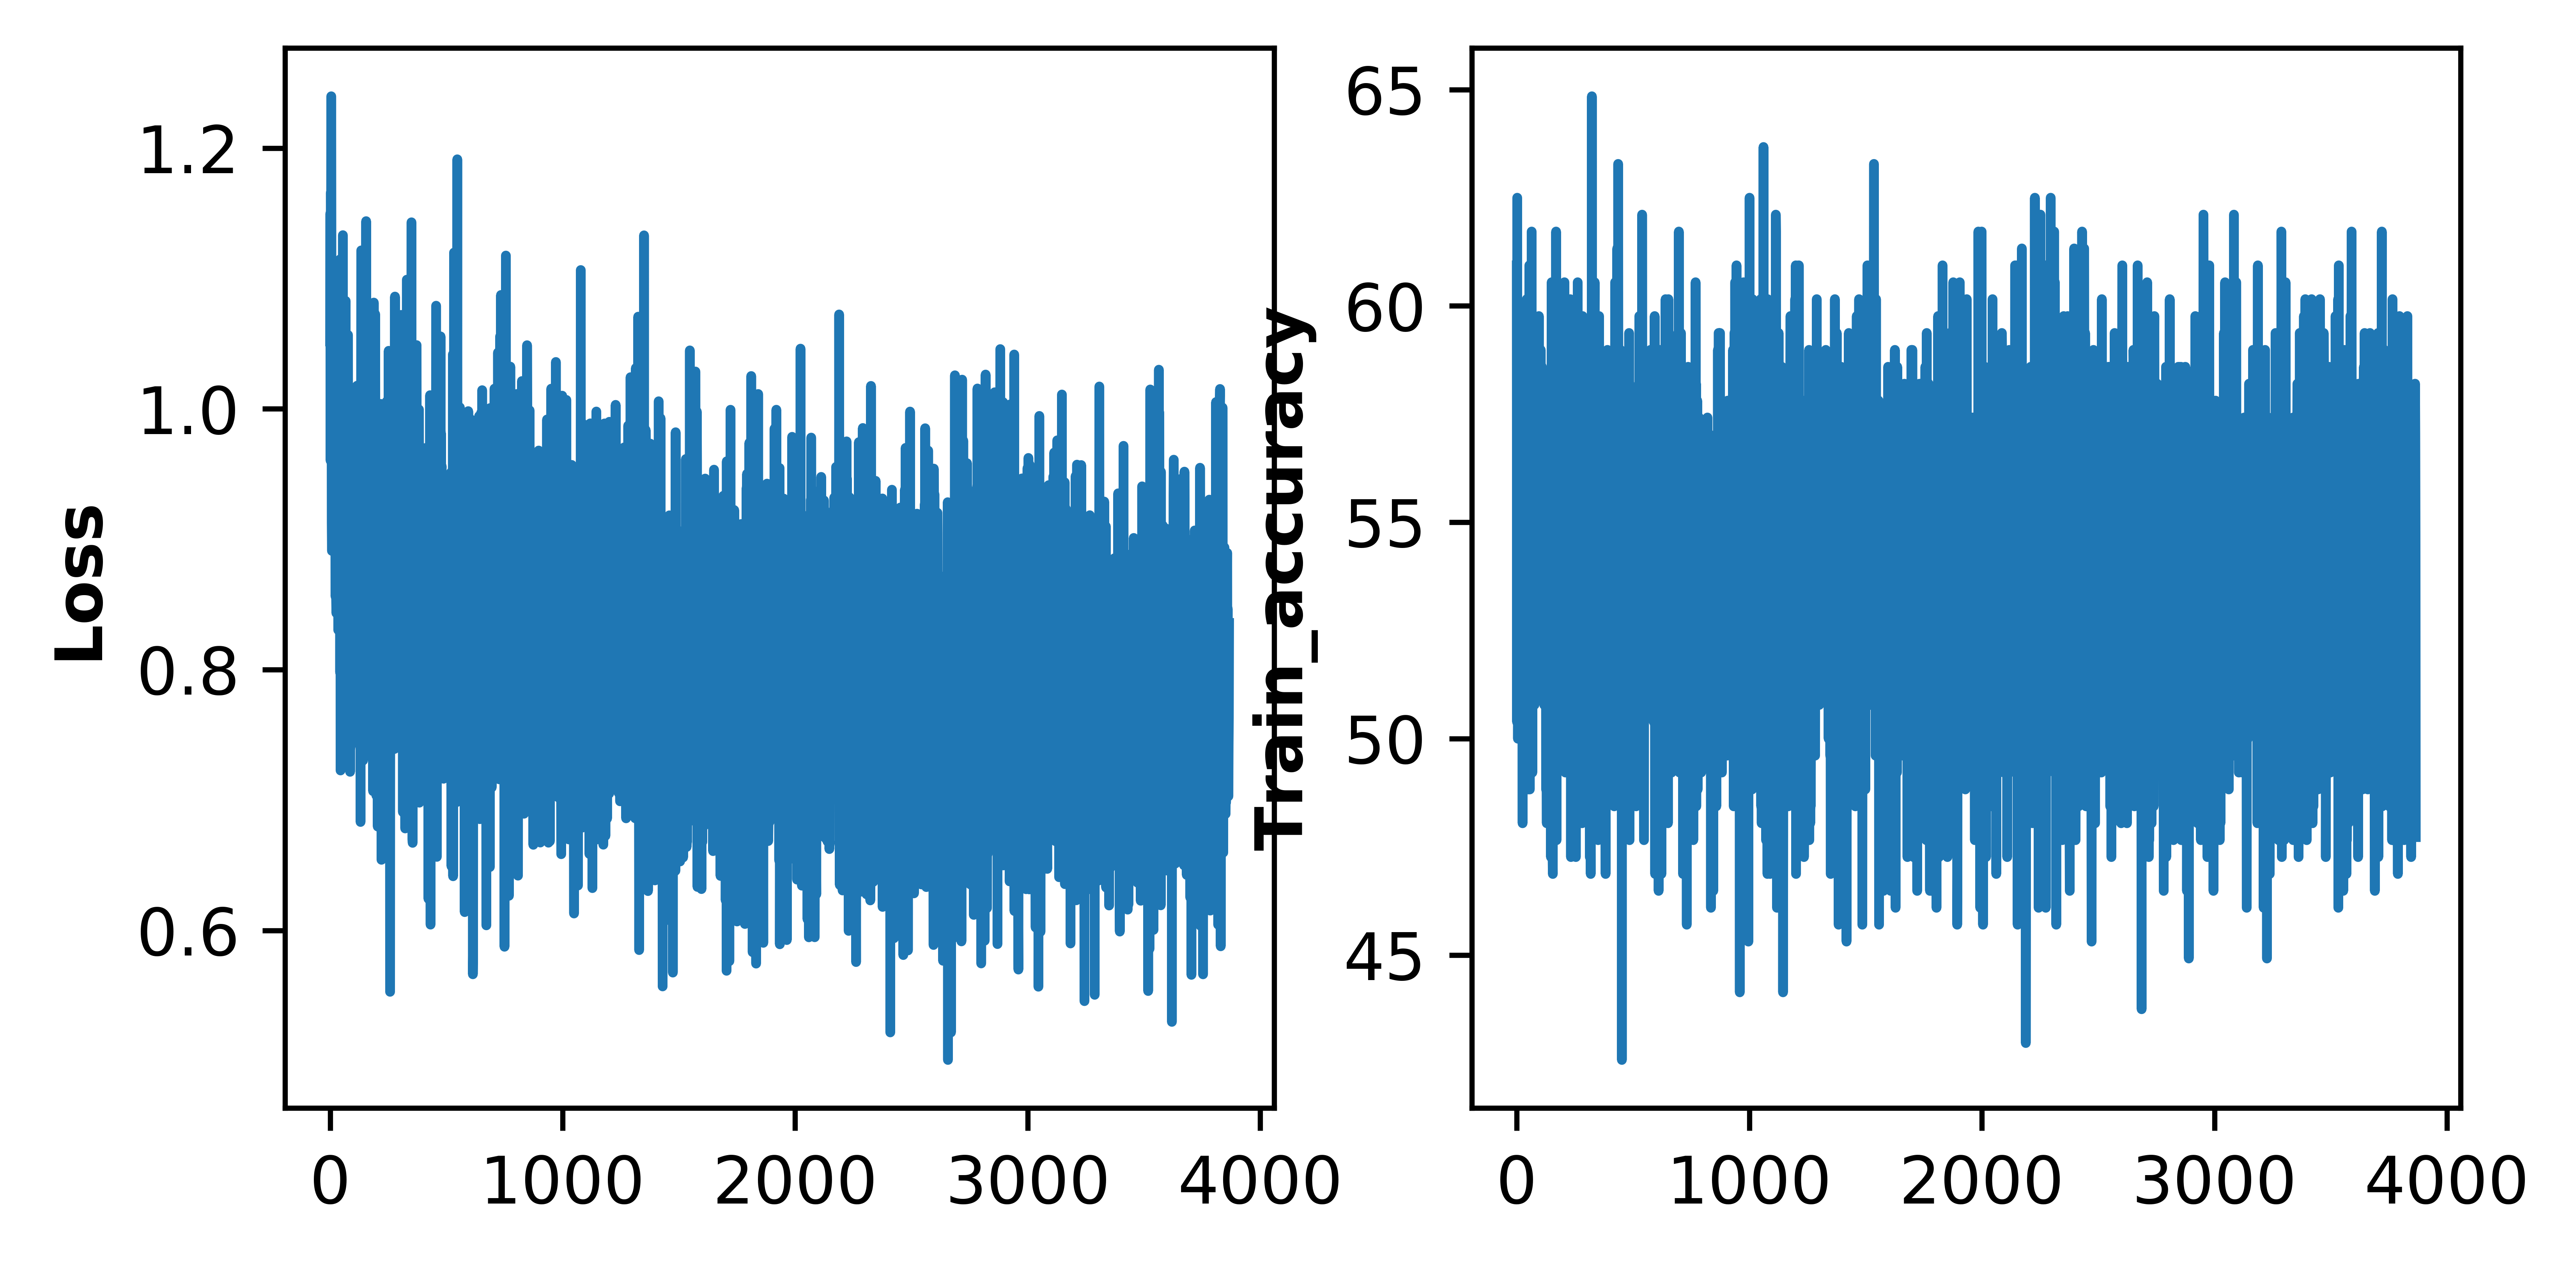

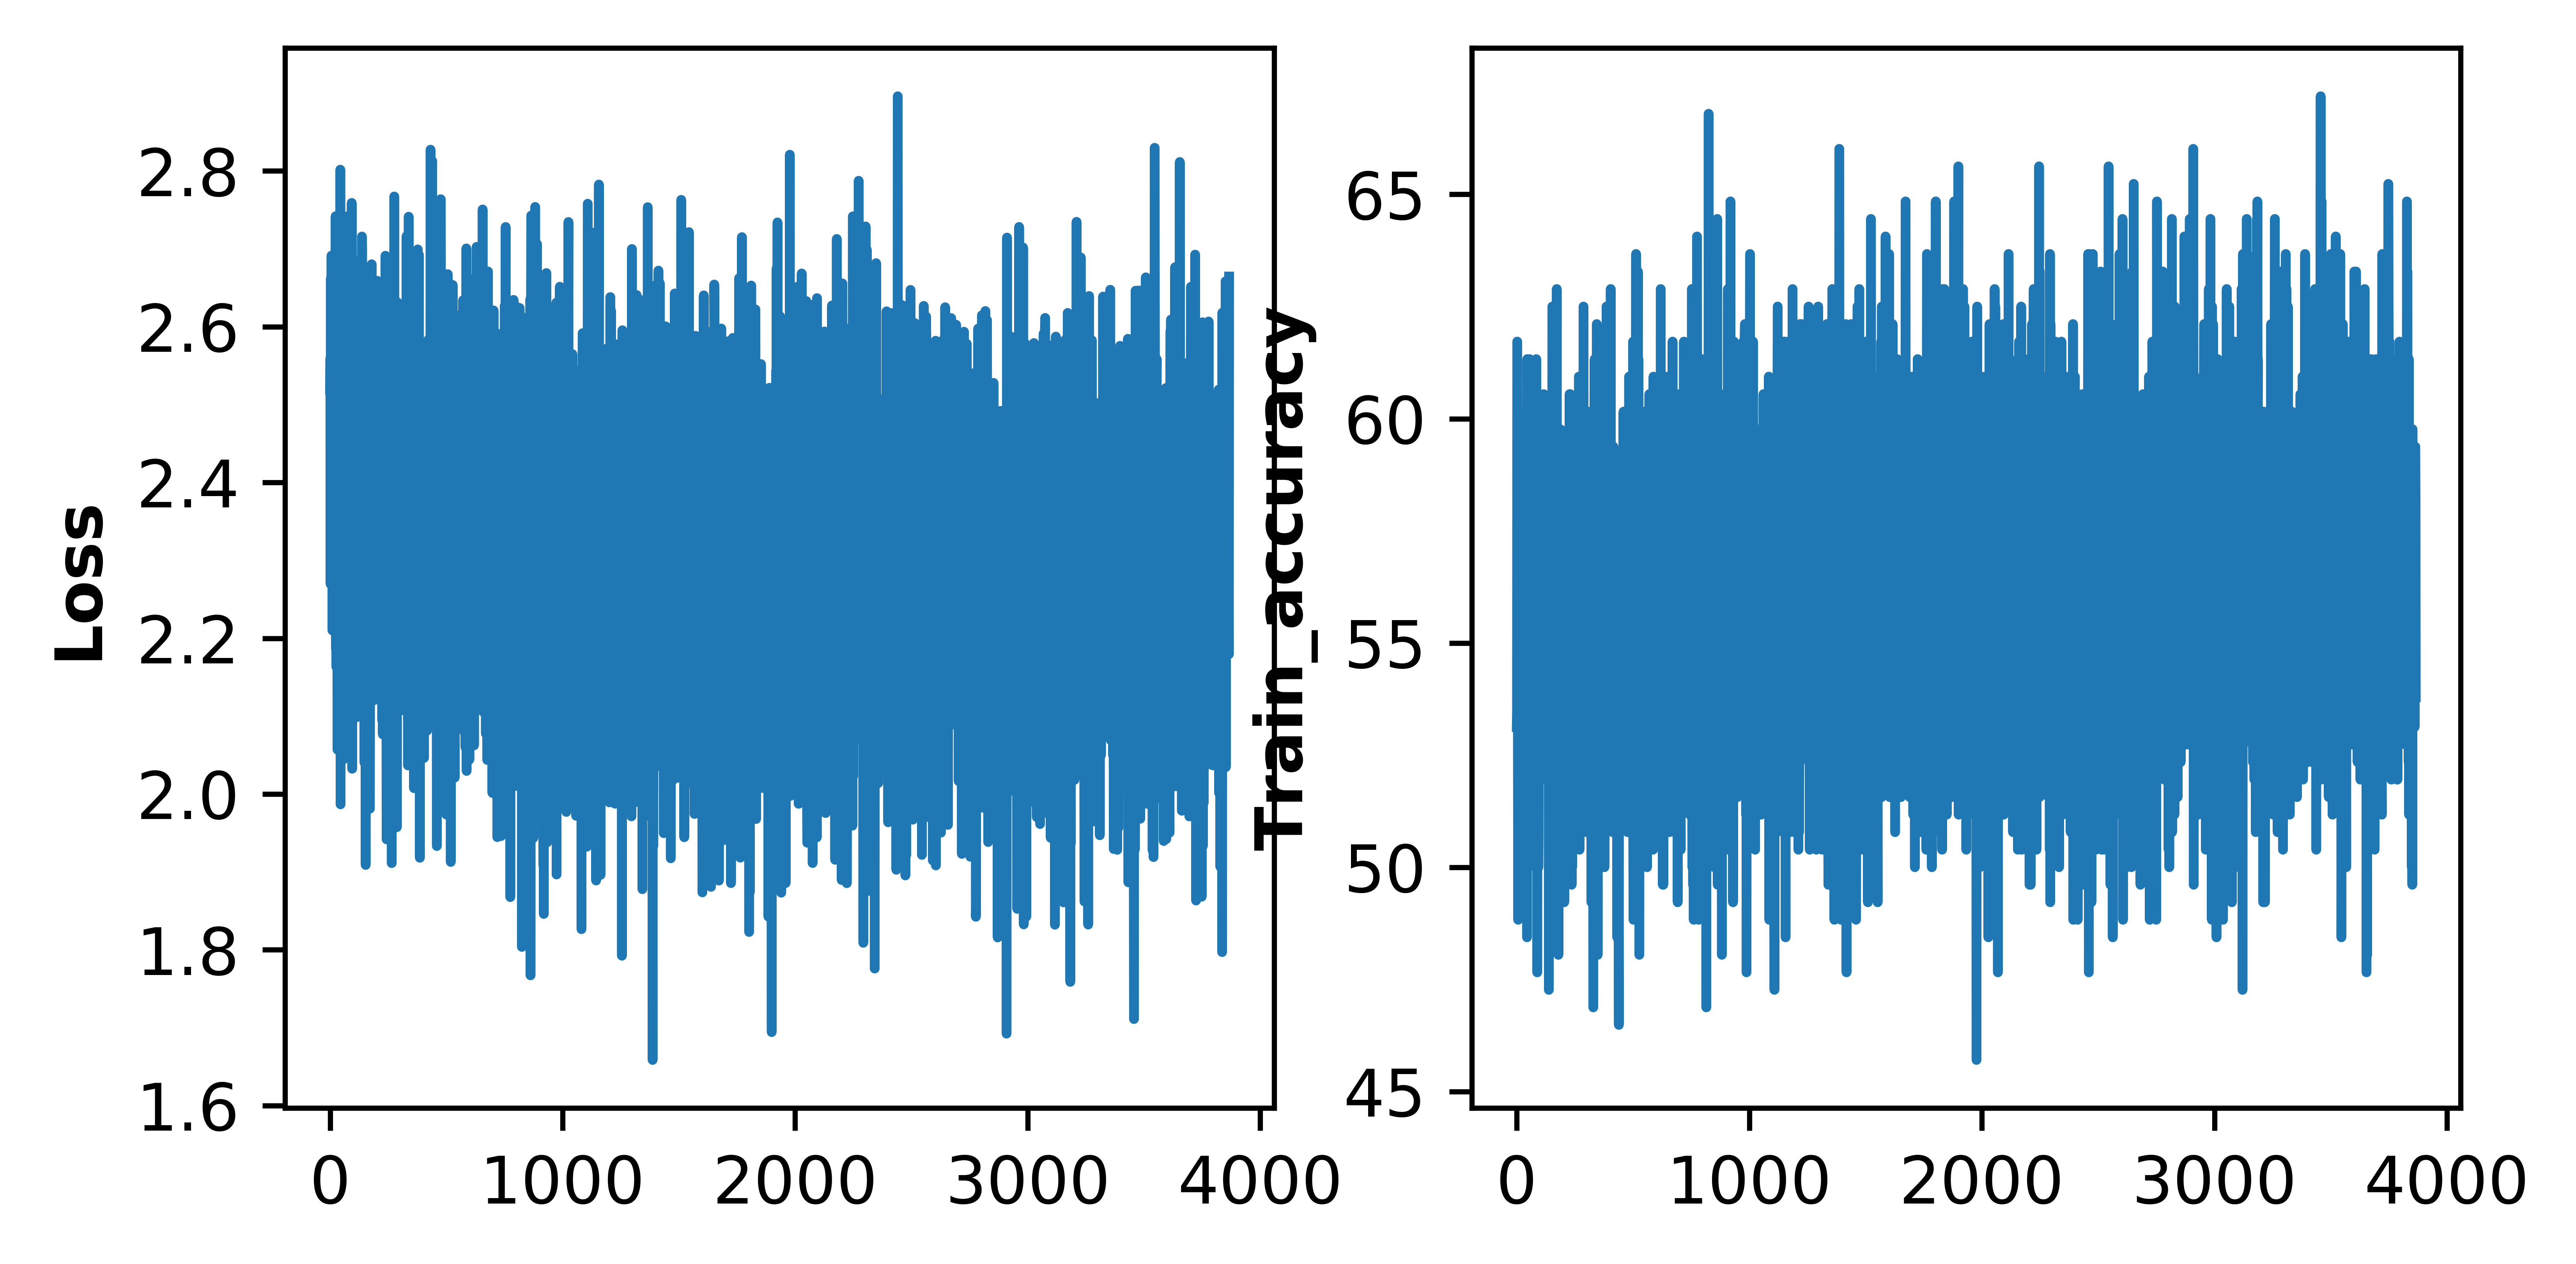

In [20]:
main()